In [0]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

np.random.seed(1)

In [0]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2
number of training examples = 1080
number of test examples = 120
X_train_shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


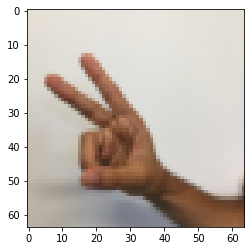

In [28]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print('y = ' + str(np.squeeze(Y_train_orig[:, index])))

X_train = X_train_orig/255
X_test = X_test_orig/255
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print('number of training examples = ' + str(X_train.shape[0]))
print('number of test examples = ' + str(X_test.shape[0]))
print('X_train_shape: ' + str(X_train.shape) )
print('Y_train shape: ' + str(Y_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))
conv_layers = {}

In [0]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    creates the place holders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
    
    Returns:
    X -- placeholder for the data input, of shape [NONE, n_H0, n_W0, n_C0] and dtype 'float'
    Y -- placeholder for the input data labels, of shape [None, n_y] and dtype float
    """
    
    X = tf.compat.v1.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype=tf.float32)
    Y = tf.compat.v1.placeholder(shape=[None, n_y], dtype=tf.float32)
    
    return X, Y


In [30]:
X, Y = create_placeholders(64, 64, 3, 6)
print('X = ' + str(X))
print('Y = ' + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 6), dtype=float32)


In [0]:
def intitialize_parameters():
  """
  Intializes weight parameters to build a neural network with tensorflow. The shapes are:
  W1  : [4, 4, 3, 8]
  W2  : [2, 2, 8, 16]

  Returns:
  parameters -- a dictionary of tensors containing W1, W2
  """

  tf.set_random_seed(1)
  W1 = tf.get_variable('W1', shape=[4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  W2 = tf.get_variable('W2', shape=[2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))

  parameters = {'W1': W1, 'W2': W2}
  return parameters

In [32]:
tf.reset_default_graph()
with tf.Session() as sess_test:
  parameters = intitialize_parameters()
  init = tf.global_variables_initializer()
  sess_test.run(init)
  print('W1[1, 1, 1] = \n' + str(parameters['W1'].eval()[1, 1, 1]))
  print('W1.shape: ' + str(parameters['W1'].shape))
  print('\n')
  print('W2[1, 1, 1] = \n' + str(parameters['W2'].eval()[1, 1, 1]))
  print('W2.shape: ' + str(parameters['W2'].shape))

W1[1, 1, 1] = 
[ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W1.shape: (4, 4, 3, 8)


W2[1, 1, 1] = 
[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
W2.shape: (2, 2, 8, 16)


In [0]:
def forward_propagation(X, parameters):
  """
  Implements the forward propagation for the model:
  CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLY CONNECTED

  Arguments:
  X -- input dataset placeholder, of shape (input size, number of examples)
  parameters -- python dictionary containing your parameters 'W1', 'W2', the shapes are given i
                initialize_parameters
  Returns:
  Z3 -- the output of the last LINEAR unit
  """

  # Retrive the parameters from the dictionary 'parameters'
  W1 = parameters['W1']
  W2 = parameters['W2']

  # CONV2D: stride of 1, padding 'SAME'
  Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
  # RELU
  A1 = tf.nn.relu(Z1)
  # MAXPOOL: window 8x8, stride 8, padding 'SAME'
  P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
  # CONV2D: filters W2, stride 1, padding 'SAME'
  Z2  = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
  # RELU
  A2 = tf.nn.relu(Z2)
  # MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
  # FLATTEN
  F = tf.contrib.layers.flatten(P2)
  # FULLY-CONNECTED without non-linear activation function (not call softmax)
  # 6 neurons in output layer
  Z3 = tf.contrib.layers.fully_connected(F, 6, activation_fn=None)

  return Z3

In [34]:
tf.reset_default_graph()

with tf.Session() as sess:
  np.random.seed(1)
  X, Y = create_placeholders(64, 64, 3, 6)
  parameters = intitialize_parameters()
  Z3 = forward_propagation(X, parameters)
  init = tf.global_variables_initializer()
  sess.run(init)
  a = sess.run(Z3, {X: np.random.randn(2, 64, 64, 3), Y: np.random.randn(2, 6)})
  print('Z3 = \n', str(a))

Z3 = 
 [[ 1.4416984  -0.24909686  5.4504986  -0.26189622 -0.20669895  1.3654672 ]
 [ 1.4070847  -0.02573191  5.08928    -0.486699   -0.40940708  1.2624857 ]]


In [35]:
def compute_cost(Z3, Y):
  """
  Compute the cost

  Arguments:
  Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
  Y -- 'true' labels vector placeholder, same shape as Z3

  Returns:
  cost - Tensor of the cost function
  """

  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
  return cost


tf.reset_default_graph()

with tf.Session() as sess:
  np.random.seed(1)
  X, Y = create_placeholders(64, 64, 3, 6)
  parameters = intitialize_parameters()
  Z3 = forward_propagation(X, parameters)
  cost = compute_cost(Z3, Y)
  init = tf.global_variables_initializer()
  sess.run(init)
  a =sess.run(cost, {X: np.random.randn(4, 64, 64, 3), Y: np.random.randn(4, 6)})
  print('cost = ' + str(a))

cost = 4.6648703


In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009, num_epochs = 100, minibatch_size = 64, print_cost = True):
  """
  Implements a three-layer Convnet in Tensorflow:
  CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FALTTEN -> FULLyCONNECTED

  Arguments:
  X_train -- training set, of shape (None, 64, 64, 3)
  Y_train -- test set, of shape (None, n_y = 6)
  X_test -- training set, of shape (None, 64, 64, 3)
  Y_test -- test set, of shape (None, n_y = 6)
  learning_rate -- learning rate of the optimization
  num_epochs -- number of epochs of the optimization loop
  minibatch_size -- size of a minibatch
  print_cost -- True to print the cost every 100 epochs

  Returns:
  train_accuracy -- real number, accuracy on the train set (X_train)
  test_accuracy -- real number, testing accuracy on the test set (X_test)
  parameters -- parameters learnt by the model. They can be used to predict
  """
  ops.reset_default_graph()         # to be able to rerun the model
  tf.set_random_seed(1)             # to keep results consistent
  seed = 3                          # to keep results consistent
  (m, n_H0, n_W0, n_C0) = X_train.shape
  n_y = Y_train.shape[1]
  costs = []                        # to keep track of the cost

  # create placeholder of the correct shape
  X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

  # initialize parameters
  parameters = intitialize_parameters()

  # Forward propagation: Build ht e forward propagation in the tensorflow graph
  Z3 = forward_propagation(X, parameters)

  # Cost function: Add cost function to tensorflow graph
  cost = compute_cost(Z3, Y)

  # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

  # Initialize all the variables globally
  init = tf.global_variables_initializer()

  # Start the session to compute the tensorflow graph
  with tf.Session() as sess:
    # Run the initialization
    sess.run(init)

    # Do the training loop 
    for epoch in range(num_epochs):
      minibatch_cost = 0
      num_minibatches = int(m / minibatch_size) # number of minibatches
      seed = seed + 1
      minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

      for minibatch in minibatches:
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        _, temp_cost = sess.run([optimizer, cost], {X: minibatch_X, Y: minibatch_Y})
        minibatch_cost += temp_cost / num_minibatches

      # Print the cost every epoch
      if print_cost == True and epoch % 5 == 0:
        print('Cost after epoch %i: %f' %(epoch, minibatch_cost))

      if print_cost == True and epoch % 1 == 0:
        costs.append(minibatch_cost)

  plt.plot(np.squeeze(costs))
  plt.ylabel('cost')
  plt.xlabel('iterations (per tens)')
  plt.title("Learning rate =" + str(learning_rate))
  plt.show()

  # Calculate the correct predictions
  predict_op = tf.argmax(Z3, 1)
  correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
  # Calculate accuracy on the test set
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  print(accuracy)
  train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
  test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
  print("Train Accuracy:", train_accuracy)
  print("Test Accuracy:", test_accuracy)
                
  return train_accuracy, test_accuracy, parameters

In [0]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
